In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

C:\Users\rache\AppData\Local\Temp\ipykernel_25384\2987880752.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='titleType', order=df['titleType'].value_counts().index, palette='Set2')


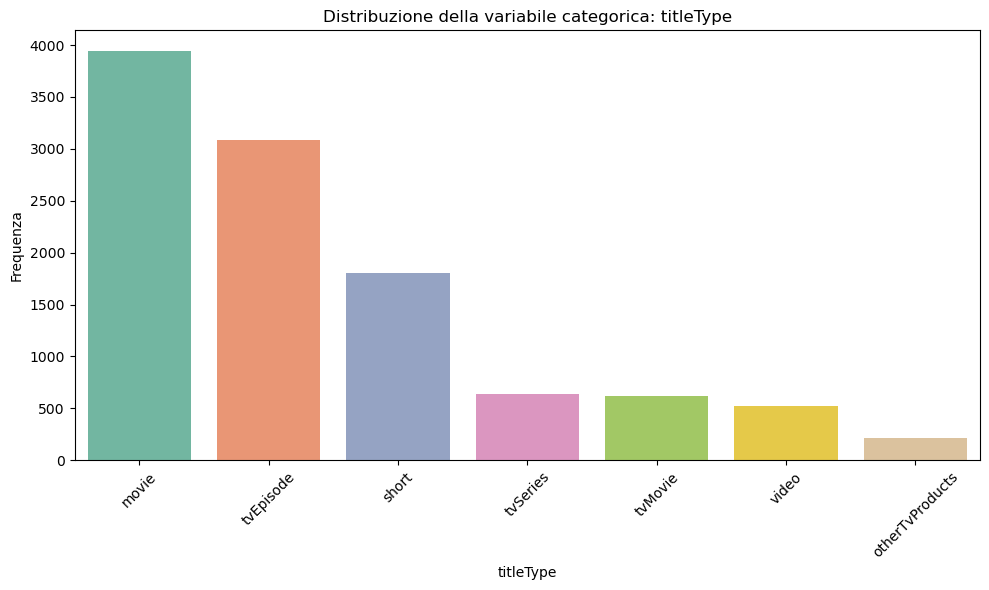

In [2]:
df = pd.read_csv('df_cleaned.csv', skipinitialspace=True, header=0)

rare_types = ['tvMiniSeries', 'tvSpecial', 'tvShort']
df['titleType'] = df['titleType'].replace(rare_types, 'otherTvProducts')

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='titleType', order=df['titleType'].value_counts().index, palette='Set2')
plt.title('Distribuzione della variabile categorica: titleType')
plt.xlabel('titleType')
plt.ylabel('Frequenza')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [3]:
X = df.drop(columns=['rating_category',"originalTitle", "countryOfOrigin", "runtimeMinutes","popularity_category", 'titleType'])
y = df['titleType']


In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer

In [5]:
# dataset division with stratify

RANDOM_STATE = 0
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

K_FOLD = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)

In [6]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# genres: MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_train = mlb.fit_transform(X_train['genres'])
genres_test = mlb.transform(X_test['genres'])

# One-hot encoding su runtime_category e continent
X_cat_train = pd.get_dummies(X_train[['runtime_category', 'continent']], drop_first=True)
X_cat_test = pd.get_dummies(X_test[['runtime_category', 'continent']], drop_first=True)

# Allineamento colonne test rispetto al train
X_cat_test = X_cat_test.reindex(columns=X_cat_train.columns, fill_value=0)

# Selezione colonne numeriche
X_num_train = X_train.select_dtypes(include=[np.number])
X_num_test = X_test.select_dtypes(include=[np.number])

# Costruzione dei dataset finali in formato DENSE
X_train_enc = np.hstack([
    X_num_train.values,
    genres_train,
    X_cat_train.values
])

X_test_enc = np.hstack([
    X_num_test.values,
    genres_test,
    X_cat_test.values
])

# per avere i nome degli attributi 
feature_names = (
    X_num_train.columns.tolist() + 
    mlb.classes_.tolist() + 
    X_cat_train.columns.tolist() 
)

X_train_enc_df = pd.DataFrame(X_train_enc, columns=feature_names)

# Verifica consistenza
print("Colonne numeriche:", X_num_train.columns.tolist())
print("X_train_enc shape:", X_train_enc.shape)
print("X_test_enc shape:", X_test_enc.shape)
print(type(X_train_enc))

assert X_train_enc.shape[1] == X_test_enc.shape[1], "Numero di colonne tra train e test non corrisponde!"


Colonne numeriche: ['rating', 'awardWins', 'totalImages', 'totalVideos', 'totalCredits', 'criticReviewsTotal', 'awardNominationsExcludeWins', 'numRegions', 'userReviewsTotal', 'decade', 'totalReviews', 'num_ratings']
X_train_enc shape: (8663, 56)
X_test_enc shape: (2166, 56)
<class 'numpy.ndarray'>


# DECISION TREE

In [7]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [8]:
dt = DecisionTreeClassifier()

In [9]:
%%time
dt.fit(X_train_enc, y_train_enc)

CPU times: total: 62.5 ms
Wall time: 64.1 ms


DecisionTreeClassifier()

In [10]:
# X_train_enc_df = pd.DataFrame(X_train_enc)
# feature_names = [col for col in X_train_enc_df.columns if col != 'popularity_category']
# plt.figure(figsize=(20, 4), dpi=300)
# plot_tree(dt, feature_names=attributes, filled=True)
# plt.show()

In [11]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

In [12]:
y_train_pred = dt.predict(X_train_enc)
y_test_pred = dt.predict(X_test_enc)

In [13]:
print('Train Accuracy %s' % accuracy_score(y_train_enc, y_train_pred))
print('Train F1-score %s' % f1_score(y_train_enc, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test_enc, y_test_pred))
print('Test F1-score %s' % f1_score(y_test_enc, y_test_pred, average=None))

Train Accuracy 1.0
Train F1-score [1. 1. 1. 1. 1. 1. 1.]

Test Accuracy 0.7543859649122807
Test F1-score [0.80701754 0.1682243  0.90555556 0.8716707  0.25660377 0.48031496
 0.41346154]


In [14]:
print(classification_report(y_test_enc, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       789
           1       0.14      0.21      0.17        43
           2       0.91      0.90      0.91       361
           3       0.87      0.87      0.87       618
           4       0.24      0.27      0.26       124
           5       0.48      0.48      0.48       127
           6       0.41      0.41      0.41       104

    accuracy                           0.75      2166
   macro avg       0.55      0.56      0.56      2166
weighted avg       0.77      0.75      0.76      2166



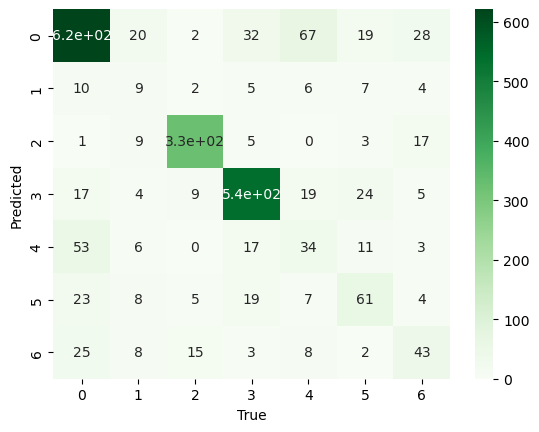

In [15]:
cf = confusion_matrix(y_test_enc, y_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

**Feauture importance**

In [16]:
zipped = zip(feature_names, dt.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

runtime_category_short 0.17603207998830073
numRegions 0.1268762880119271
h 0.11911465783292421
totalCredits 0.10130779025127393
num_ratings 0.05760563488863346
decade 0.05172334124056313
rating 0.040940443973318724
totalImages 0.03976937517308385
t 0.029516494353579763
runtime_category_medium 0.024473414948495528
totalReviews 0.01882005040512742
userReviewsTotal 0.015546407715185557
, 0.015364898545523791
A 0.01269191063193778
awardWins 0.011760644713971239
criticReviewsTotal 0.009275730452501843
awardNominationsExcludeWins 0.007763294420011155
i 0.0070975879444129825
o 0.007044898976499301
a 0.006782192392326191
- 0.006078370808442011
continent_Other 0.006011375823586813
y 0.0060029211326040185
w 0.005820031440666783
continent_North America 0.005714158654662385
continent_Asia 0.005617246068966646
continent_Europe 0.0053751935391621215
D 0.005347166644495666
S 0.0053225737086285245
C 0.004891208414431703
v 0.004453252210138215
u 0.004407414532906832
H 0.0042886150256073695
c 0.00427968

***Let us discuss overfitting***

In [17]:
nodes = []
train_err = []
test_err = []

for max_depth in list(np.arange(1, 20)):
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train_enc, y_train_enc)
    y_train_pred = dt.predict(X_train_enc)
    y_test_pred = dt.predict(X_test_enc)

    train_err.append(1 - accuracy_score(y_train_enc, y_train_pred))
    test_err.append(1 - accuracy_score(y_test_enc, y_test_pred))
    nodes.append(dt.tree_.node_count)

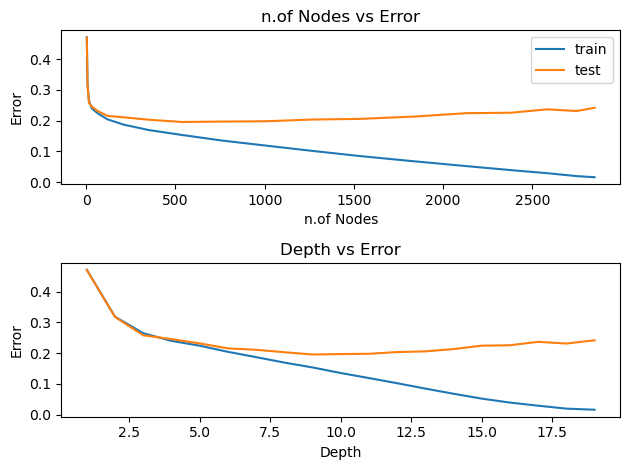

In [18]:
fig, ax = plt.subplots(2,1)
ax[0].plot(nodes, train_err, label='train')
ax[0].plot(nodes, test_err, label='test')
ax[0].legend()

ax[0].set_xlabel("n.of Nodes")
ax[0].set_ylabel("Error")
ax[0].set_title("n.of Nodes vs Error")

ax[1].plot(list(np.arange(1, 20)), train_err, label='train')
ax[1].plot(list(np.arange(1, 20)), test_err, label='test')

ax[1].set_xlabel("Depth")
ax[1].set_ylabel("Error")
ax[1].set_title("Depth vs Error")

plt.tight_layout()
plt.show()

# Randomizer Search

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import randint


In [20]:
%%time
# Definizione iperparametri
param_dist = {
    "max_depth": randint(5, 15),
    "min_samples_split": randint(10, 30),
    "min_samples_leaf": randint(5, 20),
    "criterion": ["gini", "entropy"],
    'class_weight': ['balanced']
}

# Modello
clf = DecisionTreeClassifier(random_state= RANDOM_STATE)

# Ricerca
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=50,              # 30 combinazioni casuali
    cv= K_FOLD,                   # validazione incrociata a 5 fold
    scoring='balanced_accuracy',
    random_state= RANDOM_STATE,
    n_jobs=-1               # usa tutti i core disponibili
)

# Esegui ricerca
random_search.fit(X_train_enc, y_train_enc)
clf = random_search.best_estimator_

CPU times: total: 328 ms
Wall time: 4.74 s


In [21]:
print(random_search.best_params_, random_search.best_score_)

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 19} 0.5462314082407603


In [22]:
y_test_pred = clf.predict(X_test_enc)
print("Accuracy:", accuracy_score(y_test_enc, y_test_pred))

Accuracy: 0.6094182825484764


In [23]:
clf.score(X_test_enc, y_test_enc)

0.6094182825484764

In [24]:
print('Train Accuracy %s' % accuracy_score(y_train_enc, y_train_pred))
print('Train F1-score %s' % f1_score(y_train_enc, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test_enc, y_test_pred))
print('Test F1-score %s' % f1_score(y_test_enc, y_test_pred, average=None))

Train Accuracy 0.9834930162761168
Train F1-score [0.9853125  0.96755162 0.98900344 0.99513973 0.93531283 0.98298298
 0.94102886]

Test Accuracy 0.6094182825484764
Test F1-score [0.59355962 0.12154696 0.89458689 0.79652174 0.24535316 0.41666667
 0.43859649]


In [25]:
print(classification_report(y_test_enc, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.43      0.59       789
           1       0.08      0.26      0.12        43
           2       0.92      0.87      0.89       361
           3       0.86      0.74      0.80       618
           4       0.16      0.53      0.25       124
           5       0.31      0.63      0.42       127
           6       0.40      0.48      0.44       104

    accuracy                           0.61      2166
   macro avg       0.53      0.56      0.50      2166
weighted avg       0.79      0.61      0.65      2166



In [26]:
results = pd.DataFrame(random_search.cv_results_)

<Axes: xlabel='param_max_depth', ylabel='mean_test_score'>

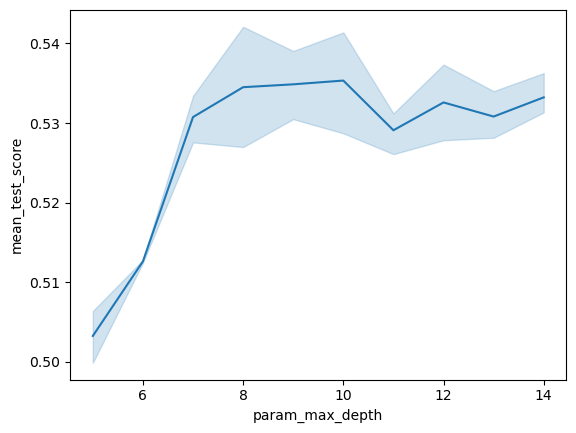

In [27]:
sns.lineplot(data=results, x="param_max_depth", y="mean_test_score")

<Axes: xlabel='param_min_samples_leaf', ylabel='mean_test_score'>

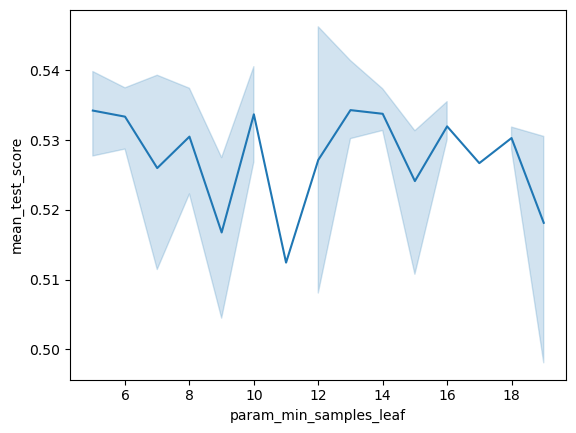

In [28]:
sns.lineplot(data=results, x="param_min_samples_leaf", y="mean_test_score")

In [29]:
zipped = zip(feature_names, clf.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

runtime_category_short 0.23000729207111129
h 0.12085307106495775
totalCredits 0.10320622897126545
decade 0.10096766632791404
numRegions 0.08314490747203737
totalImages 0.04960030486527336
num_ratings 0.04486931613338827
A 0.03695566508040072
t 0.03628030656321551
, 0.03516514263407891
rating 0.025289651443076263
runtime_category_medium 0.020866472167580762
r 0.018617089911228756
totalReviews 0.010545559088213283
- 0.008890850485921533
awardWins 0.008857510774508555
i 0.00732634957000777
l 0.006066902379755433
u 0.0059396477660097185
C 0.005129583291251067
D 0.005072361237207904
s 0.0047194654747365625
T 0.004607852834845042
continent_North America 0.0038542311048616767
d 0.0036740668638632727
criticReviewsTotal 0.0036607458415590997
n 0.0032733570063462796
v 0.002614065543992861
o 0.002514142593100757
userReviewsTotal 0.002463595187405167
S 0.0015537052650963262
a 0.0010483825069930073
c 0.001010134189684915
e 0.0009907977929284309
F 0.0003635784961828921
totalVideos 8.48398323501356e-

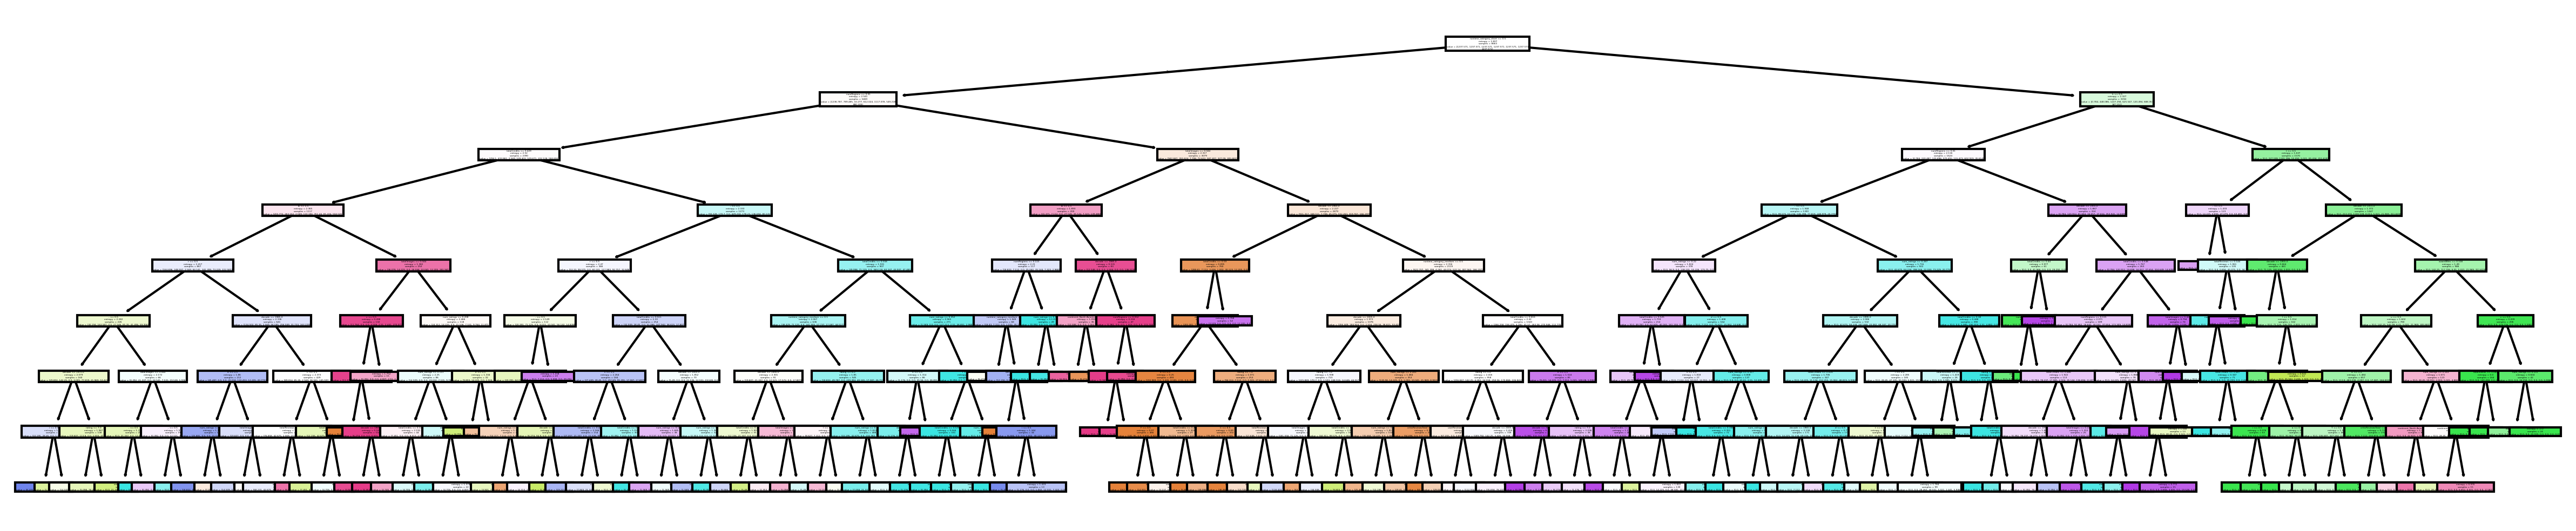

In [30]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(clf, feature_names=feature_names, filled=True)
plt.show()

# Pruning

In [31]:
def prune_and_select_tree(X_train_enc, y_train, X_test_enc, y_test_enc, base_params, random_state=RANDOM_STATE):
    # Step 1: Calcolo dei possibili alpha
    base_tree = DecisionTreeClassifier(random_state=random_state, **base_params)
    path = base_tree.cost_complexity_pruning_path(X_train_enc, y_train)
    ccp_alphas = path.ccp_alphas
   
   # Estrazione alpha e impurità evitando alpha = 0
    ccp_alphas = []
    impurities = []
    for alpha, impurity in zip(path.ccp_alphas, path.impurities):
        if alpha > 0:
            ccp_alphas.append(alpha)
            impurities.append(impurity)

    # 🔎 Step 1bis: Visualizzazione Impurity vs Alpha
    fig, ax = plt.subplots()
    ax.plot(ccp_alphas, impurities, marker='o', drawstyle='steps-post')
    ax.set_xlabel("ccp_alpha")
    ax.set_ylabel("Total Impurity")
    ax.set_title("Impurity vs alpha")
    ax.grid(True)
    plt.show()


    clfs = []
    for alpha in ccp_alphas:
        clf = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=alpha, **base_params)
        clf.fit(X_train_enc, y_train_enc)
        clfs.append(clf)

    # Step 2: Calcolo accuracy e F1 macro
    train_accuracies = [accuracy_score(y_train_enc, clf.predict(X_train_enc)) for clf in clfs]
    test_accuracies = [accuracy_score(y_test_enc, clf.predict(X_test_enc)) for clf in clfs]
    
    train_f1_scores = [f1_score(y_train_enc, clf.predict(X_train_enc), average="macro") for clf in clfs]
    test_f1_scores = [f1_score(y_test_enc, clf.predict(X_test_enc), average="macro") for clf in clfs]

    # Step 3: Selezione del modello con miglior F1 macro sul test
    best_index = np.argmax(test_f1_scores)
    best_alpha = ccp_alphas[best_index]
    best_clf = clfs[best_index]

    print(f"\n Miglior alpha selezionato: {best_alpha:.5f}")
    print(f"Test F1 macro: {test_f1_scores[best_index]:.4f}, Test Accuracy: {test_accuracies[best_index]:.4f}")

    # Step 4: Visualizzazione
    fig, ax = plt.subplots()
    ax.plot(ccp_alphas, test_f1_scores, marker="o", label="Test F1 macro", drawstyle="steps-post")
    ax.plot(ccp_alphas, test_accuracies, marker="o", label="Test Accuracy", drawstyle="steps-post")
    ax.set_xlabel("ccp_alpha")
    ax.set_title("Test performance vs alpha")
    ax.legend()
    ax.grid(True)
    plt.show()

    # Visualizzazione F1-score e Accuracy per train e test
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # F1-score
    axs[0].plot(ccp_alphas, train_f1_scores, marker='o', label="Train F1 macro", drawstyle="steps-post")
    axs[0].plot(ccp_alphas, test_f1_scores, marker='o', label="Test F1 macro", drawstyle="steps-post")
    axs[0].set_xlabel("ccp_alpha")
    axs[0].set_ylabel("F1-score")
    axs[0].set_title("F1 macro vs alpha")
    axs[0].legend()
    axs[0].grid(True)

    # Accuracy
    axs[1].plot(ccp_alphas, train_accuracies, marker='o', label="Train Accuracy", drawstyle="steps-post")
    axs[1].plot(ccp_alphas, test_accuracies, marker='o', label="Test Accuracy", drawstyle="steps-post")
    axs[1].set_xlabel("ccp_alpha")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Accuracy vs alpha")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Step 5: Valutazione finale
    y_train_pred = best_clf.predict(X_train_enc)
    y_test_pred = best_clf.predict(X_test_enc)

    print("\n Report finale - Train:")
    print("Accuracy:", accuracy_score(y_train, y_train_pred))
    print("F1-score:", f1_score(y_train, y_train_pred, average=None))
    
    print("\n Report finale - Test:")
    print("Accuracy:", accuracy_score(y_test_enc, y_test_pred))
    print("F1-score:", f1_score(y_test_enc, y_test_pred, average=None))
    print("\nClassification Report:")
    print(classification_report(y_test_enc, y_test_pred))

    return best_clf, best_alpha

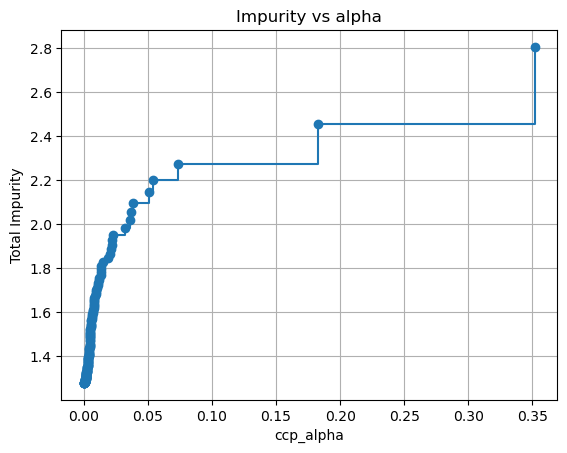


 Miglior alpha selezionato: 0.00456
Test F1 macro: 0.5276, Test Accuracy: 0.6330


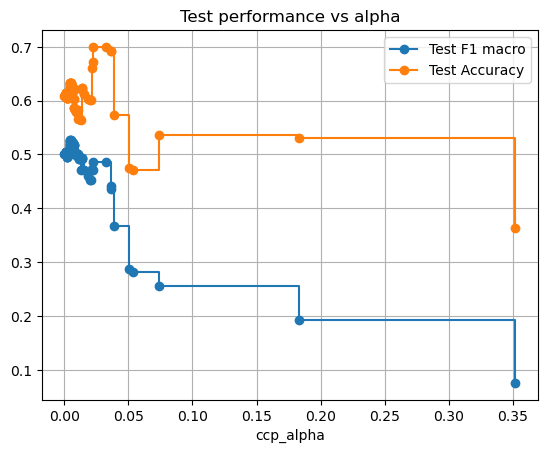

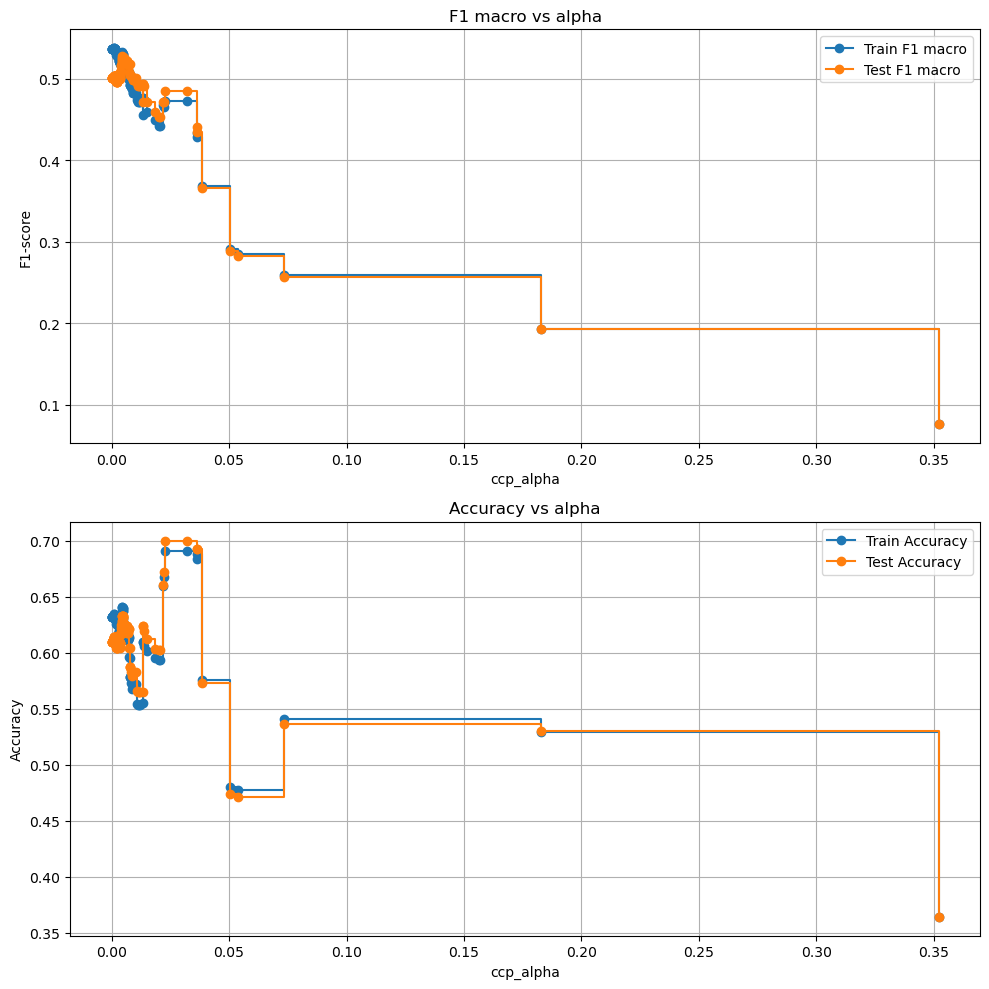


 Report finale - Train:
Accuracy: 0.6397321943899342
F1-score: [0.60090654 0.18       0.8969697  0.83220374 0.27374053 0.45644348
 0.47776366]

 Report finale - Test:
Accuracy: 0.6329639889196675
F1-score: [0.61248931 0.18404908 0.89586305 0.80924855 0.24952741 0.43126685
 0.5106383 ]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.45      0.61       789
           1       0.12      0.35      0.18        43
           2       0.92      0.87      0.90       361
           3       0.83      0.79      0.81       618
           4       0.16      0.53      0.25       124
           5       0.33      0.63      0.43       127
           6       0.57      0.46      0.51       104

    accuracy                           0.63      2166
   macro avg       0.55      0.58      0.53      2166
weighted avg       0.79      0.63      0.67      2166



In [32]:
best_params = random_search.best_params_
best_tree, best_alpha = prune_and_select_tree(
    X_train_enc,
    y_train_enc,
    X_test_enc,
    y_test_enc,
    base_params=best_params,
    random_state=0  # o qualsiasi valore tu stia usando
)

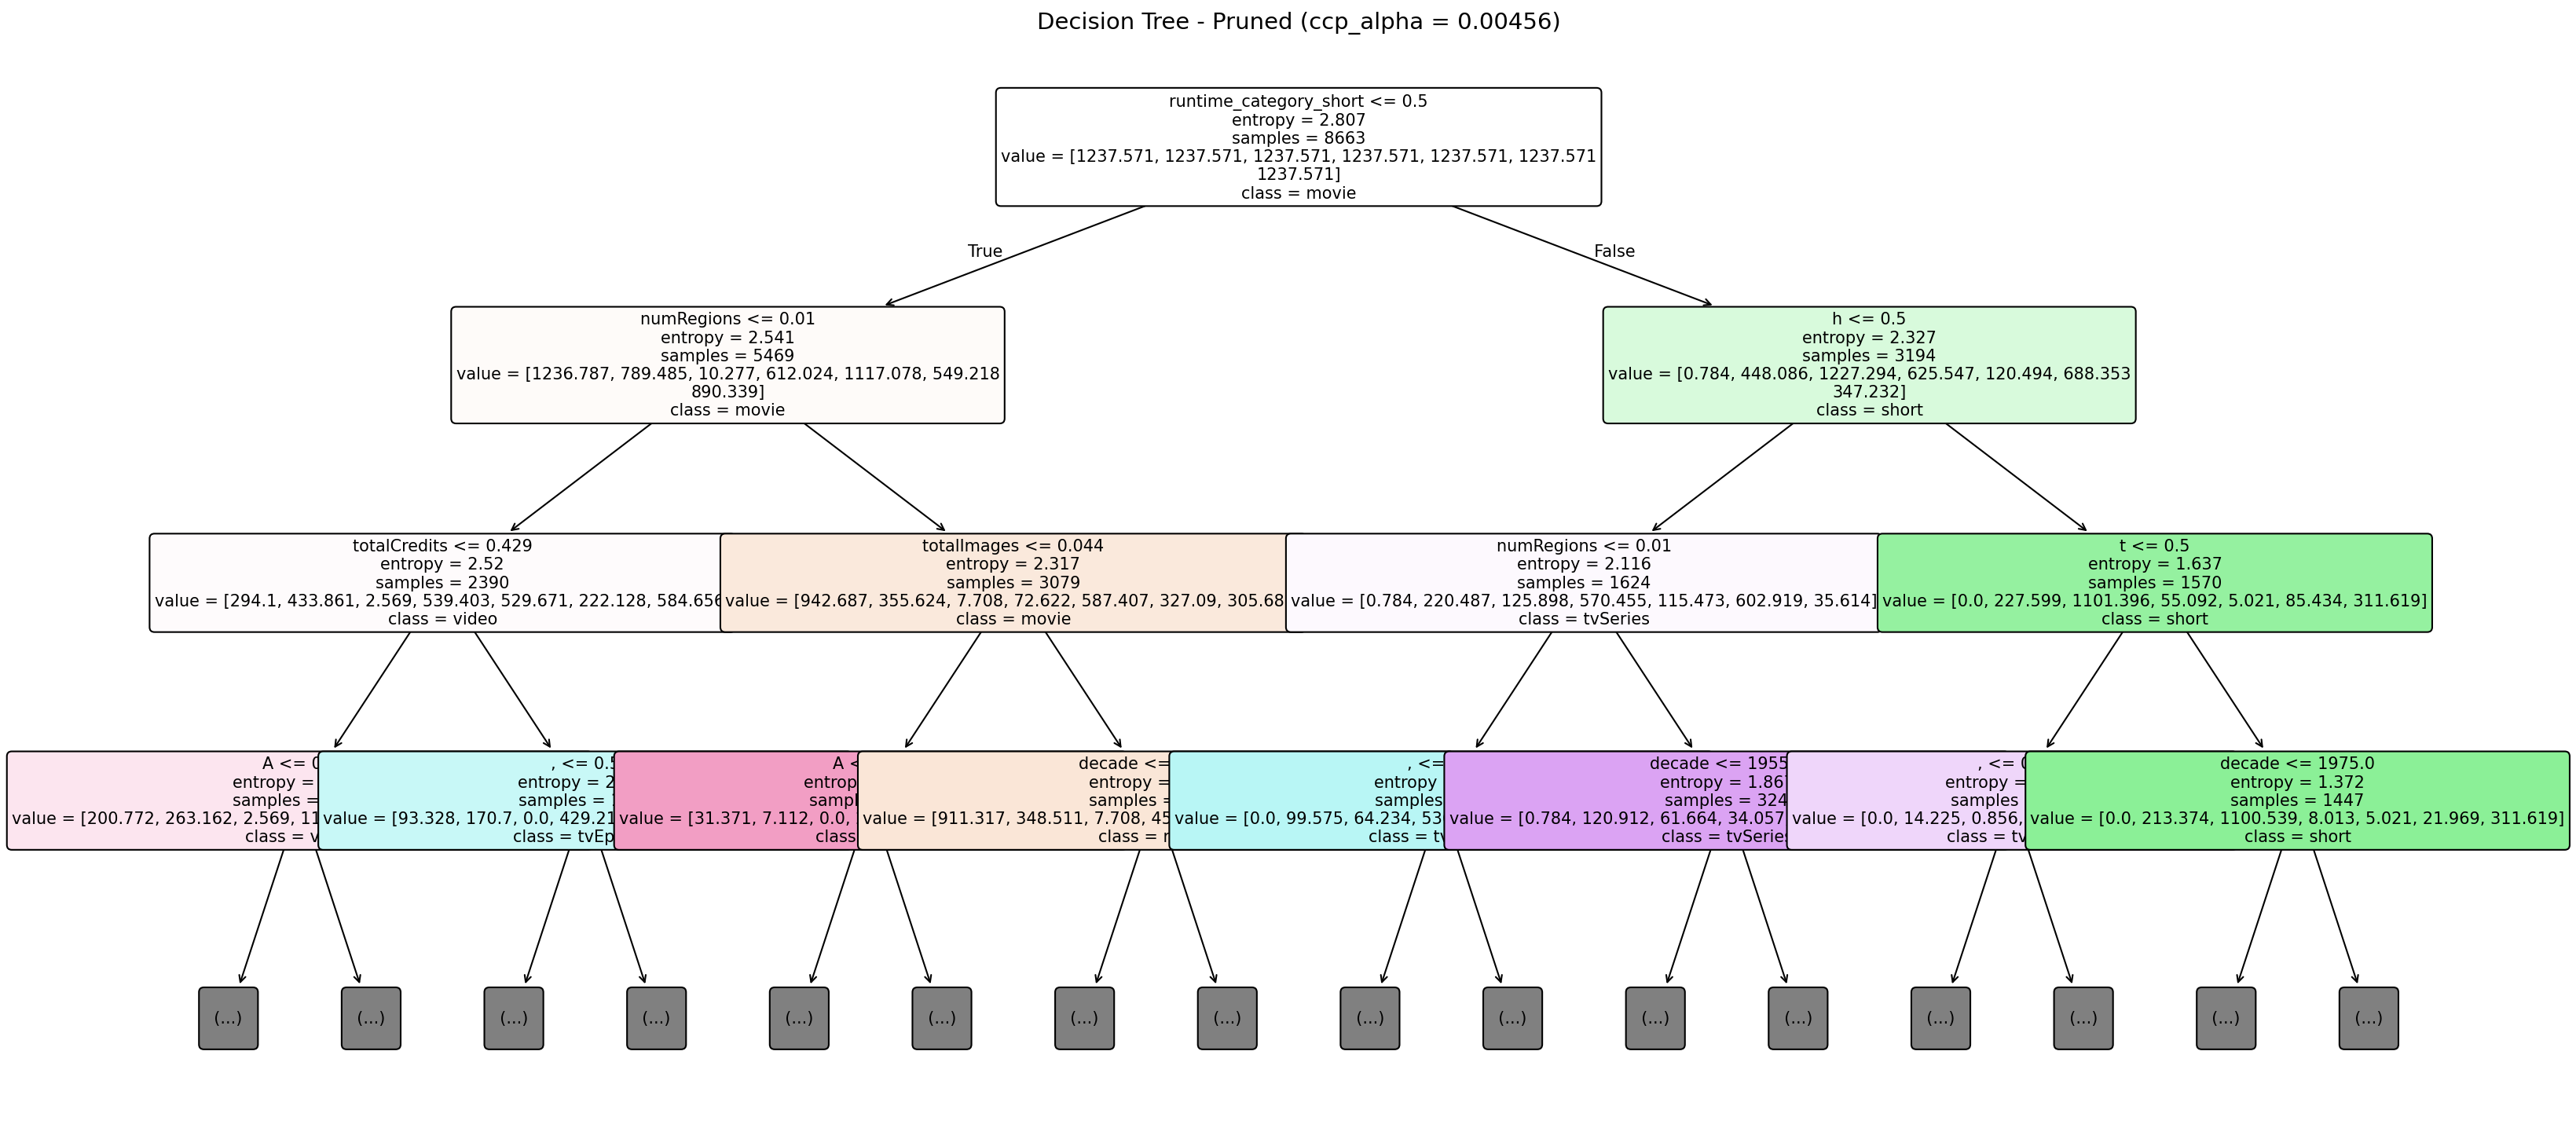

In [33]:
plt.figure(figsize=(25, 12), dpi=150)

plot_tree(
    best_tree,
    feature_names=feature_names,   # nomi delle colonne
    class_names=[str(cls) for cls in le.classes_],  # se hai usato LabelEncoder per y
    filled=True,
    rounded=True,
    max_depth=3,   # puoi rimuoverlo o aumentarlo per vedere più profondità
    fontsize=10
)

plt.title("Decision Tree - Pruned (ccp_alpha = {:.5f})".format(best_alpha), fontsize=14)
plt.show()